Here's some guide for this assessment:

1. Obtain the dataset file from the assessment instruction.
2. The dataset file is split into image and label folder. You need to find a way to read all the images and labels as numpy array.
3. The most straight forward way to read an image is to use OpenCV (cv2.imread())
4. Resize your image and label into width and height of (128,128)
5. For the label, it is in the form of binary mask image (black and white image), you need to find a way to read the mask image, then process the value of the pixels so that they become class label ([0,255] --> [0,1])
6. You can perform train test split on the numpy arrays for the images and labels using scikit learn.
7. You can convert the numpy array into tensorflow tensors using this method: tf.data.Dataset.from_tensor_slices()
8. You can combine the images and labels together to form a single dataset using this method: tf.data.Dataset.zip(), do this for both train and test data.
9. Perform the same dataset preparation step as the demo.
10. Construct a UNet, then train this model so that it reaches at least 80% accuracy for both train and test.
11. Deploy the model and make prediction

(Hint: You can refer to the image segmentation tutorial from tensorflow)

In [1]:
!git clone https://github.com/tensorflow/examples.git #only run once

fatal: Too many arguments.

usage: git clone [<options>] [--] <repo> [<dir>]

    -v, --[no-]verbose    be more verbose
    -q, --[no-]quiet      be more quiet
    --[no-]progress       force progress reporting
    --[no-]reject-shallow don't clone shallow repository
    -n, --no-checkout     don't create a checkout
    --checkout            opposite of --no-checkout
    --[no-]bare           create a bare repository
    --[no-]mirror         create a mirror repository (implies --bare)
    -l, --[no-]local      to clone from a local repository
    --no-hardlinks        don't use local hardlinks, always copy
    --hardlinks           opposite of --no-hardlinks
    -s, --[no-]shared     setup as shared repository
    --[no-]recurse-submodules[=<pathspec>]
                          initialize submodules in the clone
    --[no-]recursive ...  alias of --recurse-submodules
    -j, --[no-]jobs <n>   number of submodules cloned in parallel
    --[no-]template <template-directory>
            

In [1]:
#1. Import packages
import tensorflow as tf
from examples.tensorflow_examples.models.pix2pix import pix2pix  # tensorflow_example save in example file
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob, os

from keras import callbacks, utils

filepath = r"C:\Users\user\Downloads\SHRDC\coding\capstone\project 4\data-science-bowl-2018"
images = []
masks = []

In [2]:
#Use os.listdir() method to list down all the image file, then use a for loop to read the images.
"""
for ____ in os.listdir(____):
    function you will use here:
    os.path.join()
    cv2.imread()
    cv2.cvtColor()
    cv2.resize()

Use this for loop, do the same thing for the label. But I suggest you read the label as a grayscale image.
"""
datasets = ['test', 'train']  #file name in data science bowl 2018

images = [] #array to store images 
masks = [] #array to store masks

for dataset in datasets:

    #2. Load images
    image_path = os.path.join(filepath, dataset, 'inputs')
    
    for img in os.listdir(image_path):
        #Get the full path of the image file
        full_path = os.path.join(image_path,img)
        #Read the image file based on the full path
        img_np = cv2.imread(full_path)
        #Convert the image from bgr to rgb
        img_np = cv2.cvtColor(img_np,cv2.COLOR_BGR2RGB)
        #Resize the image into 128x128
        img_np = cv2.resize(img_np,(128,128))
        #Place the image into the empty list
        images.append(img_np)

    #3. Load masks
    mask_path = os.path.join(filepath, dataset, 'masks')
    for mask in os.listdir(mask_path):
        #Get the full path of the mask file
        full_path = os.path.join(mask_path,mask)
        #Read the mask file as a grayscale image
        mask_np = cv2.imread(full_path,cv2.IMREAD_GRAYSCALE)
        #Resize the image into 128x128
        mask_np = cv2.resize(mask_np,(128,128))
        #Place the mask into the empty list
        masks.append(mask_np)

In [3]:
#4. Convert the list of np array into a full np array
images_np = np.array(images)
masks_np = np.array(masks)

In [4]:
images_np.shape

(670, 128, 128, 3)

In [5]:
mask_np.shape

(128, 128)

In [6]:
#5. Data preprocessing
#5.1. Expand the mask dimension to include the channel axis
masks_np_exp = np.expand_dims(masks_np,axis=-1)
#5.2. Convert the mask value into just 0 and 1
converted_masks_np = np.round(masks_np_exp/255)
#5.3. Normalize the images pixel value
normalized_images_np = images_np/255.0

In [7]:
converted_masks_np.shape

(670, 128, 128, 1)

In [8]:
normalized_images_np.shape

(670, 128, 128, 3)

In [9]:
#6. Perform train test split
from sklearn.model_selection import train_test_split
SEED = 12345
X_train,X_test,y_train,y_test = train_test_split(normalized_images_np,converted_masks_np,shuffle=True,random_state=SEED)

In [10]:
#7. Convert the numpy array into tensorflow tensors
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)
y_test_tensor = tf.data.Dataset.from_tensor_slices(y_test)

In [33]:
#8. Combine features and labels together to form a zip dataset
train = tf.data.Dataset.zip((X_train_tensor,y_train_tensor))
test = tf.data.Dataset.zip((X_test_tensor,y_test_tensor))

In [13]:
train

<_ZipDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float64, name=None))>

In [14]:
test

<_ZipDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float64, name=None))>

In [34]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [35]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32

train_batches = (
    train
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))


In [36]:
BATCH_SIZE = 32
train = train.batch(BATCH_SIZE)
validation = test.batch(BATCH_SIZE)

In [37]:
validation = validation.prefetch(buffer_size=tf.data.AUTOTUNE)
train = train.prefetch(buffer_size=tf.data.AUTOTUNE)

In [38]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

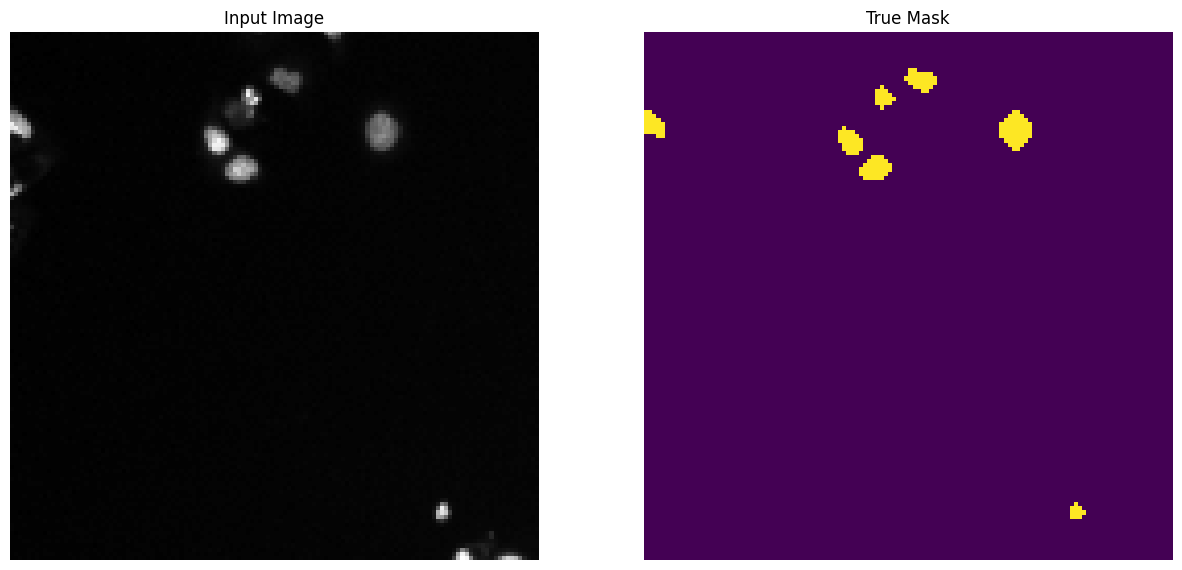

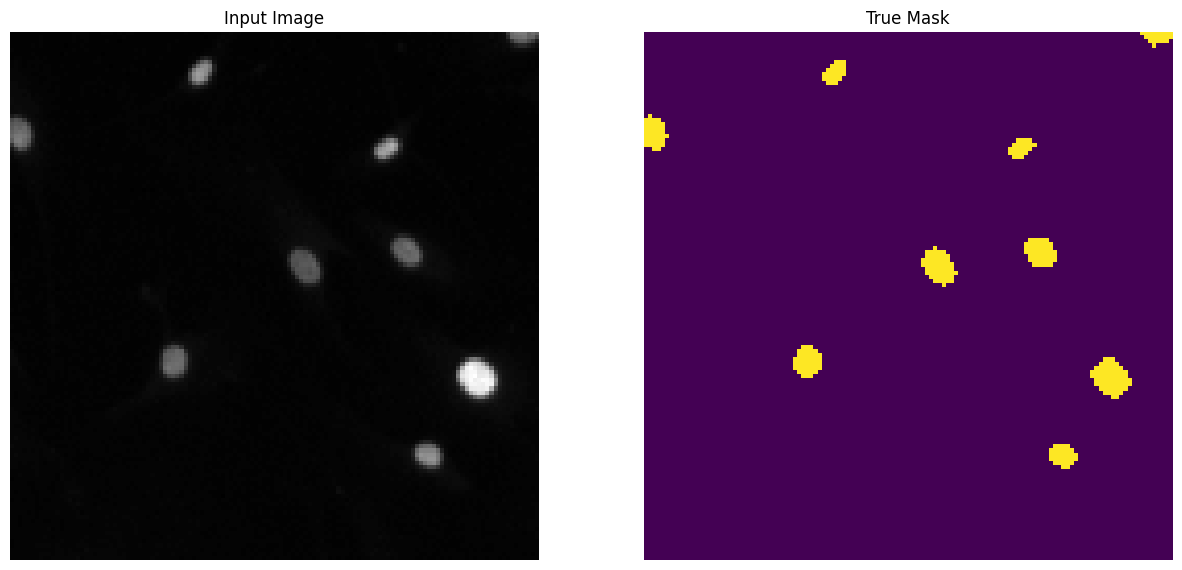

In [39]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [40]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [41]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [42]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [43]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [45]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


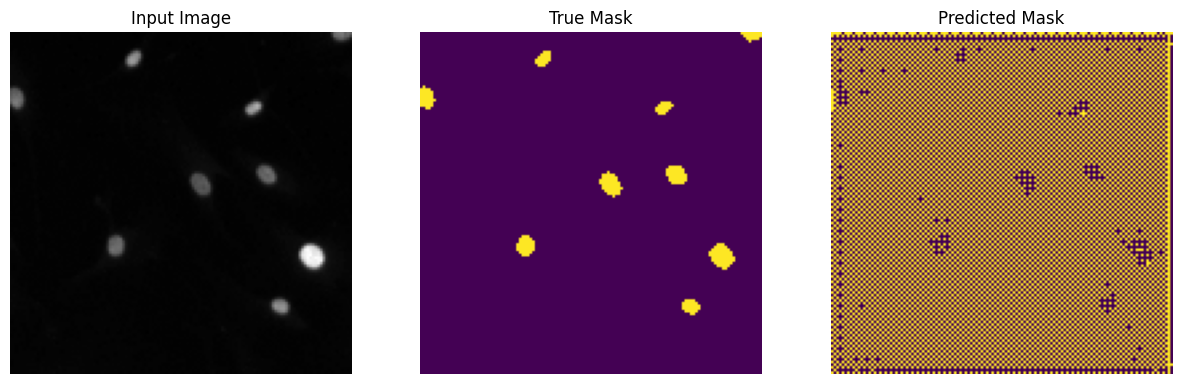

In [46]:
show_predictions()

In [47]:
prediction = model.evaluate(validation)
print(prediction)

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 580ms/step - accuracy: 0.5056 - loss: 0.8791
[0.8787997961044312, 0.5045060515403748]


In [48]:
early_stopping = callbacks.EarlyStopping(patience=3,verbose=1)

In [49]:
callbacks = [
    callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

In [50]:
EPOCHS = 20

model_history = model.fit(train, epochs=EPOCHS,
                          validation_data=validation,
                          callbacks=[early_stopping, callbacks])

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7327 - loss: 0.5603 - val_accuracy: 0.8760 - val_loss: 0.2908
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9019 - loss: 0.2194 - val_accuracy: 0.9078 - val_loss: 0.1915
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9383 - loss: 0.1495 - val_accuracy: 0.9184 - val_loss: 0.1694
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9482 - loss: 0.1262 - val_accuracy: 0.9180 - val_loss: 0.1650
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9531 - loss: 0.1145 - val_accuracy: 0.9218 - val_loss: 0.1584
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9558 - loss: 0.1081 - val_accuracy: 0.9316 - val_loss: 0.1448
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9578 - loss: 0.1033 - val_accuracy: 0.9375 - val_loss: 0.1359
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9596 - loss: 0.0987 - val_accuracy: 0.9404 - val_loss:

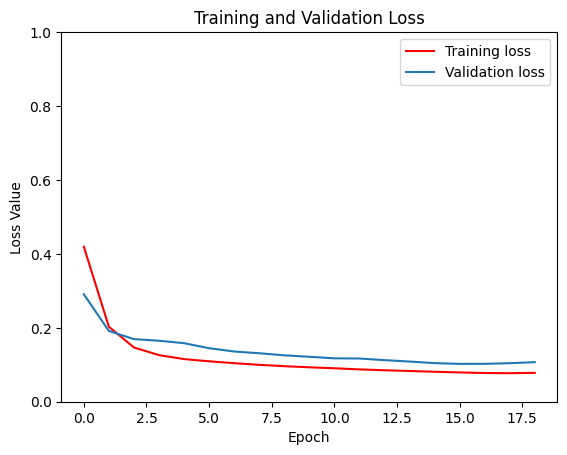

In [51]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, '-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


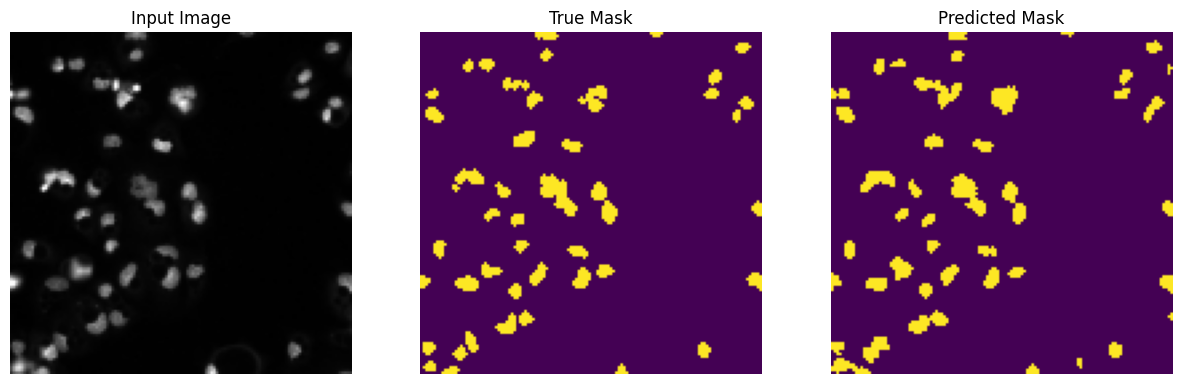

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


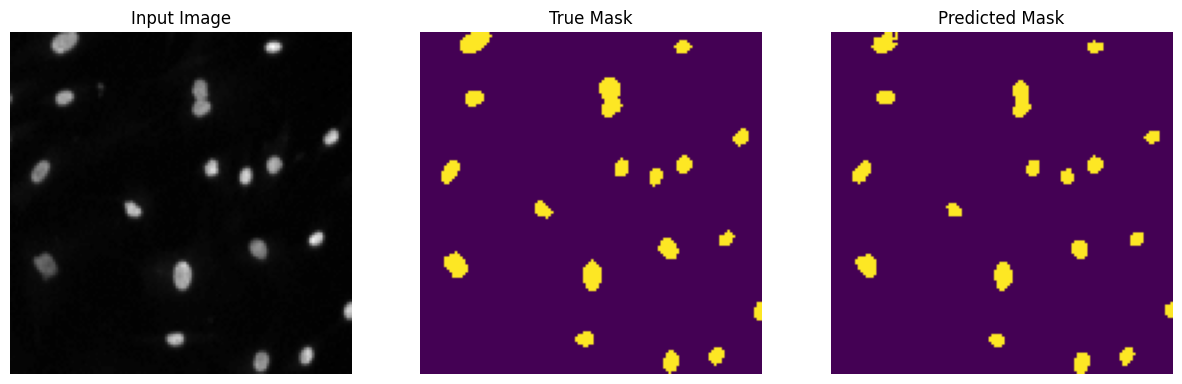

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


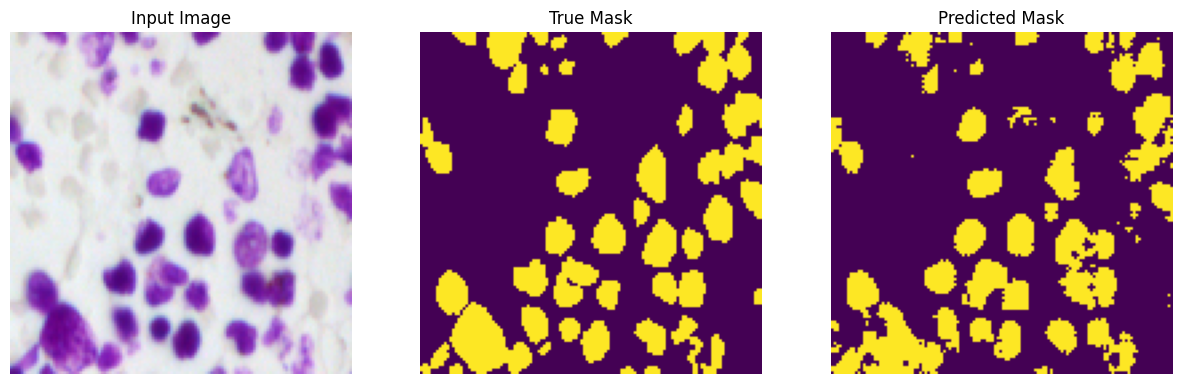

In [53]:
show_predictions(validation, 3)

In [54]:
prediction = model.evaluate(validation)
print(prediction)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 581ms/step - accuracy: 0.9578 - loss: 0.1040
[0.10701917111873627, 0.9563885927200317]


save model file

In [55]:
model.save('unet_model.h5')

Deploy the model file.

In [56]:
new_model = tf.keras.models.load_model('unet_model.h5')

print(new_model.evaluate(validation))

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 556ms/step - accuracy: 0.9578 - loss: 0.1040
[0.10701917111873627, 0.9563885927200317]
